In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from lassolver.utils.func import *
from lassolver.utils.signal import *
from lassolver.utils.utils import *

from lassolver.matrices.iid_gauss import iidGaussian
from lassolver.matrices.uni_invar import UniInvar

from lassolver.solver.amp import AMP
from lassolver.solver.oamp import OAMP

from lassolver.dsolver.d_amp import D_AMP
from lassolver.dsolver.d_oamp import D_OAMP

# 数値実験の設定

In [3]:
N = 4000  # 列数
alpha = 0.5  # 圧縮率
M = int(alpha*N)  # 行数
rho = 0.2  # 非零成分の割合

In [4]:
SNR = 60  # 信号対雑音比
kappa = 5  # 条件数
P = 50  # ノード数
T = 30  # 反復回数
sim = 100  # 実験数

# i.i.d.ガウス行列での信号再構成

In [5]:
MSE_iidG = np.empty((sim, 4, T+1))
CommCost_iidG = np.empty((sim, 2, T))

In [6]:
for i in tqdm(range(sim)):
    iidG = iidGaussian(M, N, m=0, v=1/M)
    x = bernouli_gaussian(N, rho)
    algo = [AMP(iidG.A, x, SNR), 
            D_AMP(iidG.A, x, SNR, P), 
            OAMP(iidG.A, x, SNR), 
           D_OAMP(iidG.A, x, SNR, P)]

    algo[0].estimate(T) # AMP
    algo[1].estimate(T) # D-AMP
    algo[2].estimate(T, ord='LMMSE') # OAMP
    algo[3].estimate(T, ord='LMMSE') # D-OAMP
        
    for j in range(4):
        MSE_iidG[i, j] = algo[j].mse
        if j % 2 == 1:
            k = int(j/2)
            CommCost_iidG[i, k] = algo[j].communication_cost

100%|██████████| 10/10 [07:25<00:00, 44.56s/it]


In [7]:
MSE_iidG_mean = np.empty((4, T+1))
CommCost_iidG_mean = np.empty((2, T))

for i in range(4):
    MSE_iidG_mean[i] = np.mean(MSE_iidG[:, i], axis=0)
    if i % 2 == 1:
        j = int(i/2)
        CommCost_iidG_mean[j] = np.mean(CommCost_iidG[:, j], axis=0)

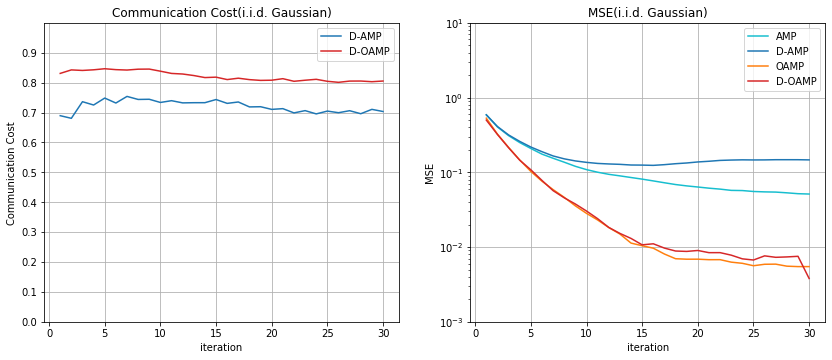

In [8]:
plt.figure(figsize=(14, 5.5))

plt.subplot(121)
plt.title('Communication Cost(i.i.d. Gaussian)')
plt_CC(CommCost_iidG_mean[0], 'D-AMP', T, N, P, 'tab:blue')
plt_CC(CommCost_iidG_mean[1], 'D-OAMP', T, N, P, 'tab:red')
plt.grid()

plt.subplot(122)
plt.title('MSE(i.i.d. Gaussian)')
plt_MSE(MSE_iidG_mean[0], 'AMP', T, 'tab:cyan')
plt_MSE(MSE_iidG_mean[1], 'D-AMP', T, 'tab:blue')
plt_MSE(MSE_iidG_mean[2], 'OAMP', T, 'tab:orange')
plt_MSE(MSE_iidG_mean[3], 'D-OAMP', T, 'tab:red')
plt.grid()

# ユニタリ不変行列での信号再構成

In [9]:
MSE_UniInv = np.empty((sim, 4, T+1))
CommCost_UniInv = np.empty((sim, 2, T))

In [10]:
for i in tqdm(range(sim)):
    UniInv = UniInvar(M, N, kappa)    
    x = bernouli_gaussian(N, rho)
    algo = [AMP(UniInv.A, x, SNR), 
            D_AMP(UniInv.A, x, SNR, P), 
            OAMP(UniInv.A, x, SNR), 
           D_OAMP(UniInv.A, x, SNR, P)]
    
    algo[0].estimate(T) # AMP
    algo[1].estimate(T) # D-AMP
    algo[2].estimate(T, ord='LMMSE') # OAMP
    algo[3].estimate(T, ord='LMMSE') # D-OAMP
        
    for j in range(4):
        MSE_UniInv[i, j] = algo[j].mse
        if j % 2 == 1:
            k = int(j/2)
            CommCost_UniInv[i, k] = algo[j].communication_cost

100%|██████████| 10/10 [07:55<00:00, 47.56s/it]


In [11]:
MSE_UniInv_mean = np.empty((4, T+1))
CommCost_UniInv_mean = np.empty((2, T))

for i in range(4):
    MSE_UniInv_mean[i] = np.mean(MSE_UniInv[:, i], axis=0)
    if i % 2 == 1:
        j = int(i/2)
        CommCost_UniInv_mean[j] = np.mean(CommCost_UniInv[:, j], axis=0)

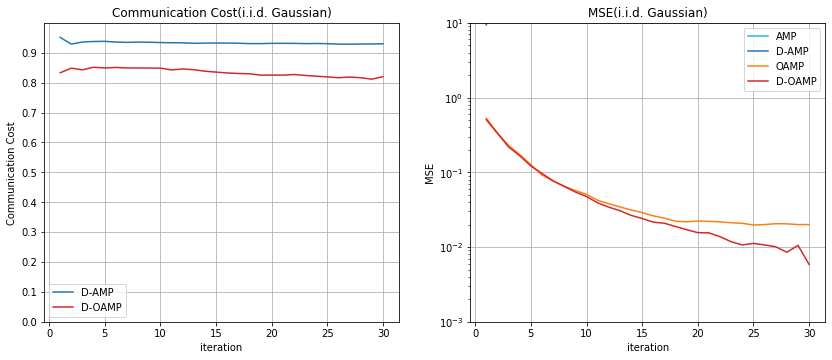

In [12]:
plt.figure(figsize=(14, 5.5))

plt.subplot(121)
plt.title('Communication Cost(i.i.d. Gaussian)')
plt_CC(CommCost_UniInv_mean[0], 'D-AMP', T, N, P, 'tab:blue')
plt_CC(CommCost_UniInv_mean[1], 'D-OAMP', T, N, P, 'tab:red')
plt.grid()

plt.subplot(122)
plt.title('MSE(i.i.d. Gaussian)')
plt_MSE(MSE_UniInv_mean[0], 'AMP', T, 'tab:cyan')
plt_MSE(MSE_UniInv_mean[1], 'D-AMP', T, 'tab:blue')
plt_MSE(MSE_UniInv_mean[2], 'OAMP', T, 'tab:orange')
plt_MSE(MSE_UniInv_mean[3], 'D-OAMP', T, 'tab:red')
plt.grid()